In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore') #忽视警告

plt.rcParams['font.sans-serif'] = ['SimHei']  # 中文字体设置-黑体
plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像是负号'-'显示为方块的问题

import jieba
import jieba.analyse
from wordcloud import WordCloud
from snownlp import SnowNLP

import gensim
from gensim import corpora
from gensim.models import LdaModel

# 读取数据

In [13]:
df = pd.read_csv(r"D:\work\github\public_opinion_data_analysis\the_queen_of_news_comments.csv")

# 分词

In [14]:
# 使用jieba进行中文分词
def chinese_segmentation(text):
    words = jieba.cut(text, cut_all=False, HMM=True)
    return " ".join(words)

In [15]:
# 从外部文件读取停用词列表
jieba.analyse.set_stop_words("stopwords.txt")

In [16]:
# 对DataFrame的'comments'列应用中文分词
df['comments_segmented'] = df['comments'].apply(chinese_segmentation)

In [17]:
# 对所有'comments_segmented'文本进行拼接
all_comments_text = " ".join(df['comments_segmented'])

# 词云分析

In [18]:
# 创建词云，并排除停用词
def generate_wordcloud(text):
    # 使用 jieba.analyse.extract_tags 提取关键词
    keywords = jieba.analyse.extract_tags(text, topK=100, withWeight=True, allowPOS=('n', 'nr', 'ns'))#allowPOS=('n', 'nr', 'ns')：表示仅考虑名词（'n'）、人名（'nr'）、地名（'ns'）等词性的词语作为关键词。这是通过词性标注来筛选关键词的一种方式。

    # 构建关键词和权重的字典
    keywords_dict = {word: weight for word, weight in keywords}

    # 创建词云
    wordcloud = WordCloud(
        width=800, 
        height=400, 
        background_color='white', 
        max_words=100, 
        collocations=False, 
        font_path= r'C:\Windows\Fonts\simhei.ttf',  # 使用支持中文的字体（黑体）
    ).generate_from_frequencies(keywords_dict)
    
    # 显示词云图像
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()


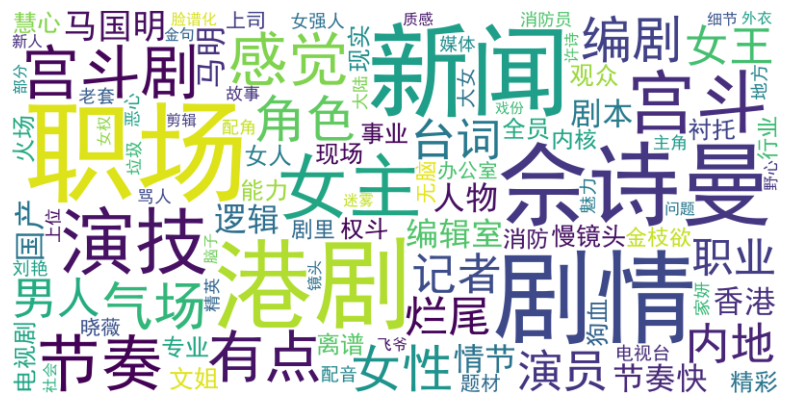

In [19]:

# 生成并显示词云
generate_wordcloud(all_comments_text)


# 

# 情感分析

In [20]:

# 添加一列来存储情感分析的结果（使用SnowNLP）
df['sentiment'] = df['comments_segmented'].apply(lambda x: SnowNLP(x).sentiments)


In [21]:
# 打印带有情感分析结果的 DataFrame
print(df[['comments_segmented', 'sentiment']])


                                     comments_segmented  sentiment
0     太 浮夸 + 全程 装 b + 剧本 太假 。 新闻记者 比 消防 警察 还 早到 现场 ？...   0.015821
1     笑 死 了 ， 小混混 无理取闹 还 抢 司机 方向盘 是 直接 导致 事故 发生 的 原因...   0.000302
2     被 评论 骗 进去 了   看 了 之后 发现自己 也 有 马失前蹄 的 时候   港剧 画...   0.997078
3     冲着 马明同 阿 佘去 的 ， 结果 大失所望 。 阿 佘 真的 不 适合 这个 角色 ， ...   0.993082
4     绷 不住 了 ， 全程 自带 装 b 光环 ➕ 油腻 表情 ， 慢镜头 这么 多 ， 平时 ...   0.075909
...                                                 ...        ...
1795                        有点 脱离实际 ， 真实 的 新闻 世界 是 这样 么   0.989967
1796                         这么久 了 ， TVB 的 实力 终于 回来 了 。   0.844097
1797  诈骗 式 营销 哈哈哈 哈哈 ， 我 还 以为 多 好看 ， 开头 就 给 我 看 傻 了 ...   0.999836
1798             剧情 有 很多 逻辑 bug ， 为了 爽 有些 太 抓 马 了 。 。 。   0.897599
1799                                       还 不错 ， 后面 看看   0.883015

[1800 rows x 2 columns]


In [22]:
df.to_excel("df_sentiment.xlsx")

# 来看看情感分析效果如何

In [23]:
df.groupby("ratings").sentiment.mean()

ratings
1    0.590736
2    0.682305
3    0.755353
4    0.844787
5    0.821564
Name: sentiment, dtype: float64

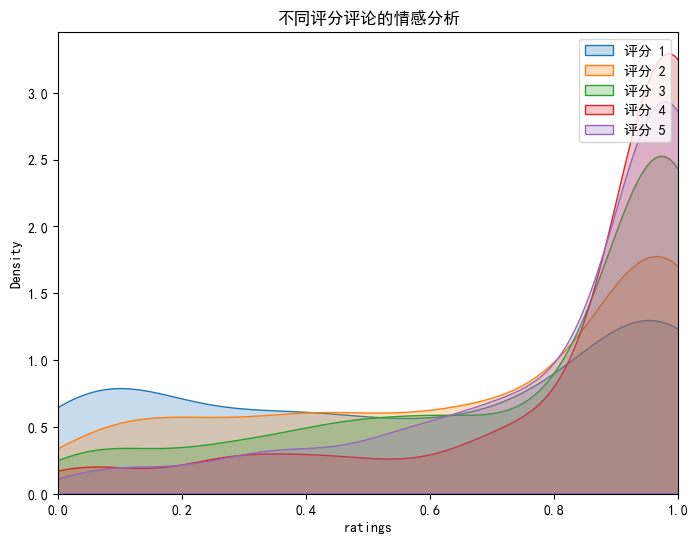

In [24]:

# 使用groupby对数据进行分组
grouped = df.groupby('ratings')

# 创建一个绘图区域
plt.figure(figsize=(8, 6))

# 遍历分组并绘制核密度图
for name, group in grouped:
    sns.kdeplot(group['sentiment'], label=f'评分 {name}', shade=True, common_norm=True)

# 设置 x 轴的限制
plt.xlim(0, 1)

# 添加图例和标签
plt.legend()
plt.title('不同评分评论的情感分析')
plt.xlabel('ratings')
plt.ylabel('Density')

# 显示图形
plt.show()


# LDA分析

In [25]:
# 加载停用词表
stop_words_path = 'stopwords.txt'  # 请替换为你的停用词表路径
stop_words = [line.strip() for line in open(stop_words_path, 'r', encoding='utf-8').readlines()]

# 分词
df['comments_segmented'] = df['comments_segmented'].apply(lambda x: [word for word in jieba.cut(x) if word not in stop_words])

# 将分好词的评论组成一个列表
documents = df['comments_segmented'].tolist()

# 创建语料库和字典
dictionary = corpora.Dictionary(documents)
corpus = [dictionary.doc2bow(text) for text in documents]

# 执行LDA模型
lda_model = LdaModel(corpus, num_topics=3, id2word=dictionary, passes=15)

# 打印主题
topics = lda_model.print_topics(num_words=5)
for topic in topics:
    print(topic)

(0, '0.001*"😍" + 0.001*"吹过" + 0.001*"作业" + 0.001*"流水线" + 0.001*"诗涵"')
(1, '0.648*" " + 0.005*"新闻" + 0.004*"剧" + 0.004*"职场" + 0.003*"剧情"')
(2, '0.001*"3.5" + 0.001*"失望" + 0.001*"emmmm" + 0.001*"weak" + 0.001*"无功"')


In [26]:
# import pyLDAvis
# import pyLDAvis.gensim_models as gensimvis

In [27]:
# # 创建可视化
# vis_data = gensimvis.prepare(lda_model, corpus, dictionary)
# pyLDAvis.display(vis_data)